### Importing library

In [380]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [381]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten
from keras.callbacks import EarlyStopping

In [382]:
# Setting format for visualizing data
from matplotlib import rcParams
rcParams["font.weight"] = "bold"
rcParams["axes.labelweight"] = "bold"

rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['axes.labelweight'] = 'bold'
rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.it'] = 'STIXGeneral:italic'
rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'

In [383]:
# Define function for constructing input data
def split_data(data, n_input, n_out): 
    in_start = 0
    X, y = list(), list()   
    for _ in range(len(data)):
        
        in_end = in_start + n_input
        out_end = in_end + n_out
        
        if out_end < len(data):
            X.append(data[in_start:in_end])
            y.append(data[in_end:out_end])
        
        in_start += n_out
    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1]), y.reshape(y.shape[0], y.shape[1])

In [384]:
# for reproducibility
np.random.seed(100)

### Load dataset

In [387]:
dataset = pd.read_csv('galway2th.csv', names=['hs'])

nan = np.nan
dataset = dataset.interpolate(method='cubic') # Data Interpolation

hs = dataset

### Standardize the data
For optimizing performance during training.

In [388]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_hs = scaler.fit_transform(hs)

Text(0, 0.5, 'Hs [m]')

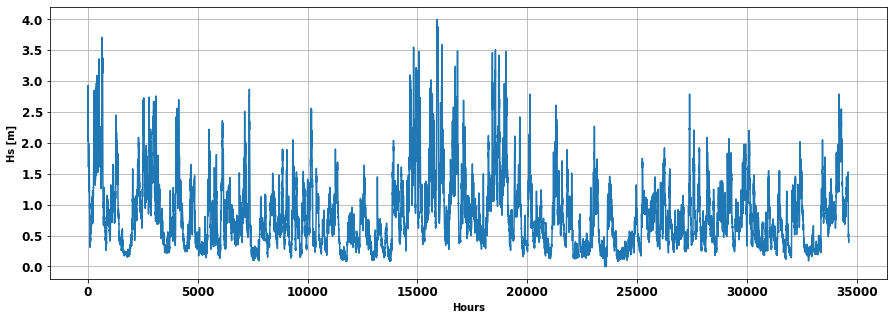

In [389]:
# Plot raw data
plt.figure(figsize=(15,5))
plt.plot(hs)
plt.grid()
plt.xlabel('Hours')
plt.ylabel('Hs [m]')

In [390]:
# splitting data
n_train = int(len(scaled_hs)*0.70)
n_test = len(scaled_hs) - n_train
train, test = scaled_hs[0:n_train, :], scaled_hs[n_train:len(scaled_hs),:]

### Creating input data

In [391]:
look_back = 12 # number of input data in previous time step
n_out = 1
trainX, trainY = split_data(train, look_back, n_out)
testX, testY = split_data(test, look_back, n_out)

In [392]:
pd.DataFrame(trainX).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.5075,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125
1,0.5225,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125
2,0.5800,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875
3,0.5850,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625
4,0.6200,0.6925,0.6800,0.6825,0.7075,0.7125,0.7325,0.7125,0.6125,0.5875,0.5625,0.5575


### Reshaping data (1D - 3D)
In LSTM, the input data should be in 3D shape (sample, time step, feature).

In [395]:
trainX_r = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1)) # Baris - timestep - kolom
trainY_r = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testX_r = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
testY_r = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX_r.shape, trainY.shape)

(24230, 12, 1) (24230, 1)


### LSTM Model

In [396]:
from keras.layers import TimeDistributed, RepeatVector

batch_size=1
model = Sequential()
model.add(Bidirectional(LSTM(40, activation='tanh', input_shape=(trainX.shape[1], 1),
                             batch_input_shape=(batch_size, look_back, 1))))
model.add(RepeatVector(trainY.shape[1]))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(40, activation='tanh', dropout=0.3, recurrent_regularizer='l2', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='nadam', loss='mse')


## Running Model with Early Stopping Method

In [397]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, 
                           patience=10, verbose=0, mode='auto', 
                           baseline=None, restore_best_weights=False)]

history = model.fit(trainX_r, trainY_r, 
                    validation_split=0.1, 
                    epochs = 20, batch_size=10, 
                    verbose=1, 
                    callbacks = callbacks)


Train on 21807 samples, validate on 2423 samples
Epoch 1/20
21807/21807 [==============================] - 169s 8ms/step - loss: 0.0110 - val_loss: 1.2446e-04
Epoch 2/20
21807/21807 [==============================] - 164s 8ms/step - loss: 5.2288e-04 - val_loss: 1.8803e-04
Epoch 3/20
21807/21807 [==============================] - 165s 8ms/step - loss: 4.7285e-04 - val_loss: 1.1241e-04
Epoch 4/20
21807/21807 [==============================] - 164s 8ms/step - loss: 4.4108e-04 - val_loss: 2.3572e-04
Epoch 5/20
21807/21807 [==============================] - 165s 8ms/step - loss: 4.1454e-04 - val_loss: 1.4328e-04
Epoch 6/20
21807/21807 [==============================] - 163s 7ms/step - loss: 4.1252e-04 - val_loss: 2.4043e-04
Epoch 7/20
21807/21807 [==============================] - 164s 8ms/step - loss: 4.0458e-04 - val_loss: 1.4839e-04
Epoch 8/20
21807/21807 [==============================] - 170s 8ms/step - loss: 4.0094e-04 - val_loss: 1.5152e-04
Epoch 9/20
21807/21807 [===================

### Predict over train and test data

In [399]:
trainPredict = model.predict(trainX_r)
testPredict = model.predict(testX_r)

In [401]:
#trainPredict = scaler.inverse_transform(trainPredict.reshape(trainPredict.shape[0], trainPredict.shape[1]))
#trainY = scaler.inverse_transform(trainY.reshape(trainY.shape[0], trainY.shape[1]))
#testPredict = scaler.inverse_transform(testPredict.reshape(testPredict.shape[0], testPredict.shape[1]))
#testY = scaler.inverse_transform(testY.reshape(testY.shape[0], testY.shape[1]))

### Evaluate the model

In [403]:
rmse_train = math.sqrt(mean_squared_error(trainY_r.flatten(), trainPredict.flatten()))
rmse_test = math.sqrt(mean_squared_error(testY_r.flatten(), testPredict.flatten()))
bias_train = np.mean(trainPredict.flatten() - trainY.flatten())
bias_test = np.mean(testPredict.flatten() - testY.flatten())

print('RMSE Train data : %.2f cm' %(rmse_train*100))
print('RMSE Test data : %.2f cm' %(rmse_test*100))
print('Bias Train :', bias_train)
print('Bias Test : ', bias_test)

RMSE Train data : 1.65 cm
RMSE Test data : 1.23 cm
Bias Train : 0.00272488916930068
Bias Test :  0.002337629693646632


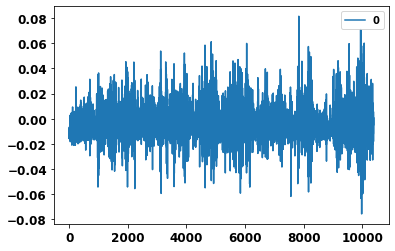

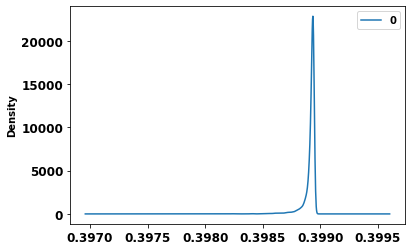

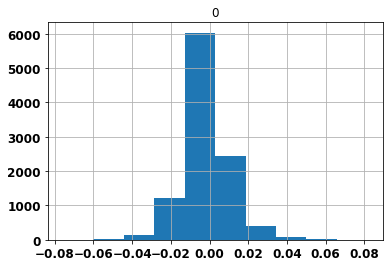

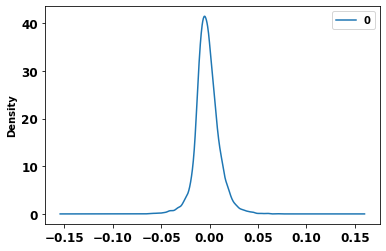

In [406]:
from scipy.stats import norm

residual_test = pd.DataFrame(testY.flatten() - testPredict.flatten())
residual_test.plot()
m, s = norm.fit(residual_test)
#dist_norm = pd.DataFrame(norm.pdf(residual_test, m, s))
dist_norm = pd.DataFrame(norm.pdf(residual_test))
dist_norm.plot(kind='kde')
plt.show()
residual_test.hist()
residual_test.plot(kind='kde')
plt.show()

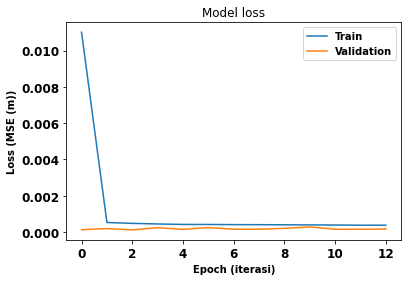

In [407]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE (m))')
plt.xlabel('Epoch (iterasi)')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


### Visualize the result

In [408]:
# data for plot
trainPredictPlot = np.empty_like(hs) # membuat matriks kosong dgn dimensi sama seperti raw data
trainPredictPlot[:,:] = np.nan # mengisi matriks tsb dgn NaN
trainPredictPlot[look_back:len(trainPredict.flatten())+look_back, :] = np.array([trainPredict.flatten()]).T # mengsinkronkan skala dgn hasil prediksi

testPredictPlot = np.empty_like(hs)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict.flatten())+(look_back*2)+1 : len(hs)-1, :] = np.array([testPredict.flatten()]).T


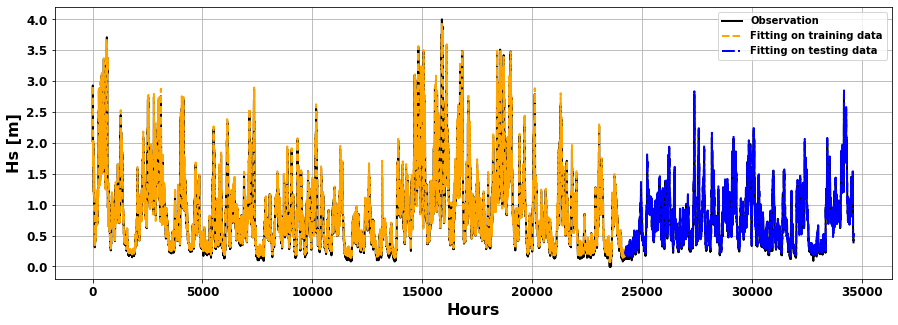

In [409]:
trainPredictPlot_inv = scaler.inverse_transform(trainPredictPlot.reshape(-1,1))
testPredictPlot_inv = scaler.inverse_transform(testPredictPlot.reshape(-1,1))

plt.figure(figsize=(15,5))
plt.plot(hs, linestyle = '-', color='black', marker='', linewidth =2, label='Observation')
plt.plot(trainPredictPlot_inv, linestyle = '--', marker='', color='orange', linewidth=2, label='Fitting on training data')
plt.plot(testPredictPlot_inv, linestyle = '-.', marker='', color='blue', linewidth=2, label='Fitting on testing data')

plt.xlabel('Hours', fontsize=16)
plt.ylabel('Hs [m]', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

### Predicting Hs

In [426]:
def predict_hs(input_pred, look_back, n_out):
  
  last_lb = input_pred
  pred_out = list()

  ni = 0
  for i in range(0, int(12/n_out)): # 48 hours multi-step prediction
    last_lb_r = last_lb.reshape(1, look_back, 1) # (n_example, n_timestep, n_feature)
    pred = model.predict(last_lb_r)
    last_lb = np.append(last_lb, pred)
    last_lb = np.array([last_lb])
    ni = n_out
    last_lb = last_lb[:, ni:]
    pred.tolist()
    pred_out.extend(pred)

  pred_out = np.array(pred_out)
  pred_out = pred_out.reshape(pred_out.shape[0],pred_out.shape[1])
  pred_out = pred_out.flatten()

  return pred_out


In [411]:
def plot_predict(input_pred, pred_out, obs_data):

  f = np.linspace(1,72,72)

  onx = np.array([pred_out]).shape[1]
  obs = obs_data.flatten()

  plt.figure(figsize=(15,6))
  plt.plot(f[:onx], pred_out, linestyle='-', marker='o', color='blue', label='Predicted') #o
  plt.plot(f[:onx], obs, linestyle='-', marker='^', color='black', label='Observation') #^
  plt.xlabel('Hours',fontweight='bold', fontsize=16)
  plt.ylabel('$\it{Hs}$ (m)', fontweight='bold', fontsize=16)
  #plt.ylim(0, 2)
  plt.legend()
  plt.grid()

Sampel Prediction on Testing Data



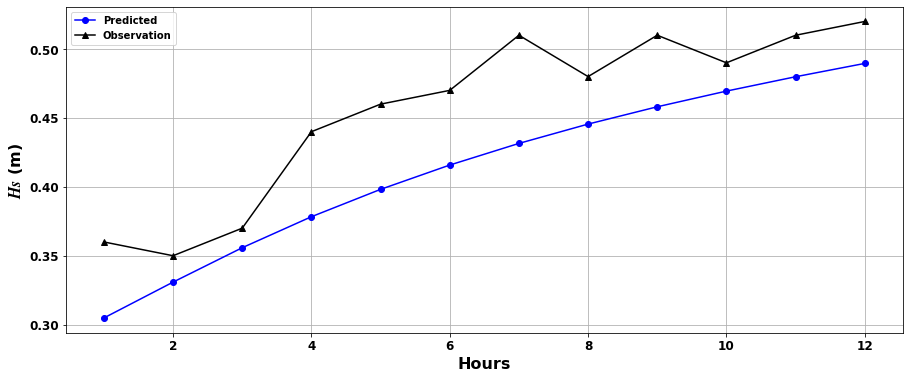

In [433]:
print('Sampel Prediction on Testing Data\n')
sam = 1772
look_back = testX.shape[1]
pred_sam = predict_hs(testX[sam], look_back, n_out)

# rescaling data into original
testY_inv = scaler.inverse_transform(testY)
obs_sam_inv = testY_inv[sam:sam+12]
pred_sam_inv = scaler.inverse_transform(np.array(pred_sam).reshape(-1,1))
plot_predict(testX[sam], pred_sam_inv, obs_sam_inv) 

In [434]:
obs_sam = testY_inv[sam:sam+12].flatten() 
rmse_pred = math.sqrt(np.mean((pred_sam_inv-obs_sam)**2))
print('RMSE sampel:', rmse_pred*100,'cm')

from scipy.stats import pearsonr

korelasi = pearsonr(pred_sam, obs_sam)
print('Korelasi, p-value:', korelasi)
print('Bias:',np.mean(pred_sam_inv-obs_sam))

RMSE sampel: 9.347903191345347 cm
Korelasi, p-value: (0.9449161750110319, 3.6397918155815744e-06)
Bias: -0.04268089443445206
